**Goal:**

1. Provide a cheap "black-box" wrapper for an expensive function $f$. When initialized, we define (1) a predictor function $\hat{f}$ that models the expensive function's input-output relationship, (2) a predictive variance function $\sigma^2_\text{pred}(\mathbf{x})$, and (3) a tolerance threshold $\sigma^2_\text{tol}$ for the predictive variance. When queried at a point $\mathbf{x}$, we check whether the predictive variance satisfies the tolerance threshold, $\sigma^2_\text{pred}(\mathbf{x}) \leq \sigma^2_\text{tol}$. If so, we return the cheap prediction. If not, we call the ground-truth function $f(\mathbf{x})$ and update $\hat{f}$.
2. Plug this "black-box" wrapper into an MCMC algorithm instead of $f$
3. Profit!

In [1]:
import numpy as np
import numpy.random as npr
import GPy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# step 1!

In [3]:
class GP_Wrapped_Function():
    def __init__(self,
                 f_callable,
                 predictive_var_tolerance=0.1,
                 initial_observations=[]):
        
        '''
        f_callable is the black-box function we're wrapping.
        
        predictive_var_tolerance is the maximum predictive variance we are
        willing to tolerate without calling f_callable.
        
        initial_observations is a list of (x,y) pairs
        '''
        
        self.f_groundtruth = f_callable
        self.predictive_var_tolerance_ = predictive_var_tolerance
        self.observations_ = inital_observations
        self.fit_count_ = 0 # number of times the model has been fit
        self.fit_model() # assigns to self.model_
        
    def fit_model(self):
        self.fit_count_ += 1
        X = np.array([pair[0] for pair in self.observations_])
        y = np.array([pair[1] for pair in self.observations_])
        if len(y[0].shape == 1):
            y = y.reshape((len(y),1)) # GPy expects y to be 2 dimensional, i.e. to have shape (N,1) rather than (N,)
        
        # replace with sparse GP?
        self.model_ = GPy.models.GPRegression(X,y)
        self.model_.optimize()
    
    def update_model(self,new_observations):
        # currently re-training from scratch
        # to-do: efficient incremental updates
        
        self.observations.append(new_observations)
        self.fit_model()
    
    def __call__(self,X):
        ''' assume X is an N-by-d array of points to be evaluated at.'''
        
        # evaluate the model at all queried points, storing prediction and predictive variance
        y_pred,y_pred_var = self.model_.predict(X)
        y_return = np.array(y_pred)
        
        # bit-vector of which queries yielded an intolerable predictive variance
        unpredictables = y_pred_var > self.predictive_var_tolerance_
        
        # if there are any queries for which we'll need to consult the groundtruth function, do so
        # and update the model accordingly
        if sum(unpredictables) > 0:
            batch_update_x = X[unpredictables]
            batch_update_y = np.array([self.f_groundtruth(x) for x in batch_update_x])
            self.update_model(zip(batch_update_x,batch_update_y))
            y_return[unpredictables] = batch_update_y

        return y_return

In [4]:
class Black_Box():
    def __init__(self,function):
        self.call_count_ = 0
        self.function_ = function
    
    def __call__(self,x):
        self.call_count_ += 1
        return self.function_(x)

test_fxn = Black_Box(lambda x:np.sum(np.sin(x**2)))

npr.seed(0)
train_range = 5
X_train = npr.rand(100,1)*train_range - (train_range / 2.0)
y_train = np.array([test_fxn(x) for x in X_train]).reshape((len(X_train),1))

test_range = train_range*2.0
X_test = npr.rand(1000,1)*test_range - (test_range / 2.0)
y_test = np.array([test_fxn(x) for x in X_test]).reshape((len(X_test),1))

#init_observations = zip(X_train,y_train)

In [6]:
# fit a GP to the training set and make predictions on the test set
regressor = GPy.models.GPRegression(X_train,y_train)
regressor.optimize()
y_pred,y_pred_var = regressor.predict(X_test)

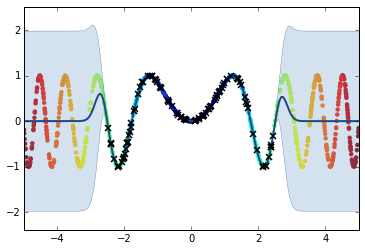

In [7]:
regressor.plot([X_test.min(),X_test.max()])
plt.scatter(X_test,y_test,c=np.abs(X_test),linewidths=0)

Color represents x-coordinate of each test point


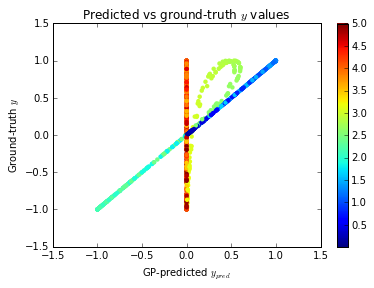

In [8]:
# plot predicted vs ground-truth y values
plt.scatter(y_pred,y_test,c=np.abs(X_test),linewidths=0)
plt.xlabel(r'GP-predicted $y_{pred}$')
plt.ylabel(r'Ground-truth $y$')
plt.title(r'Predicted vs ground-truth $y$ values')
plt.colorbar()
print('Color represents x-coordinate of each test point')
# the diagonal is a low-error regime in which the GP is being tested in the range it was trained
# the loop of green-ish dots represent predictions made slightly outside the range of training points
# the vertical line is a high-error regime in which the GP is being tested far outside the range in which
# it was trained and simply predicts the mean function 0

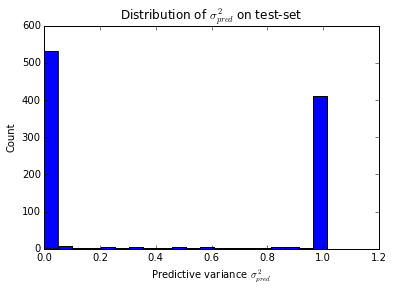

In [9]:
plt.hist(y_pred_var,bins=20);
plt.xlabel(r'Predictive variance $\sigma^2_{{pred}}$')
plt.ylabel('Count')
plt.title(r'Distribution of $\sigma^2_{{pred}}$ on test-set')

In [10]:
# step 2!

In [11]:
import emcee